In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
# Libraries
print("\tImporting libraries...\n")
import sys; sys.path.append("..")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

# ml libraries
from sklearn.metrics import r2_score

# dl libraries
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
torch.set_float32_matmul_precision('high')

# ext. libraries
import src.utils as utils
import src.models as models
from src.visuals import CustomVisualizer
print("\tImport complete!\n")

utils.set_plt_style()
device = utils.get_device_info()
seed = utils.set_all_seeds()

NUM_WORKERS = 23
DATASET_NAME = "mimic-iv-ecg"
DATASET_DIR = os.path.join("..", "data", DATASET_NAME)
OUTPUT_DIR = os.path.join("..", "out", DATASET_NAME)
SCORE_METRIC = 'test_r2'
score_metric = r2_score

	Importing libraries...



Seed set to 42



=== Environment Information ===
Python version: 3.12.2
PyTorch version: 2.6.0
NumPy version: 1.26.4
Platform: macOS-15.4.1-arm64-arm-64bit

	Import complete!


=== Device Information ===
CUDA available: False
Using device: cpu


=== Setting Random Seeds ===
Seed value: 42
Setting torch CPU seed...
Setting torch CUDA seed...
Setting numpy seed...
Configuring CUDNN...
Configuring PL...



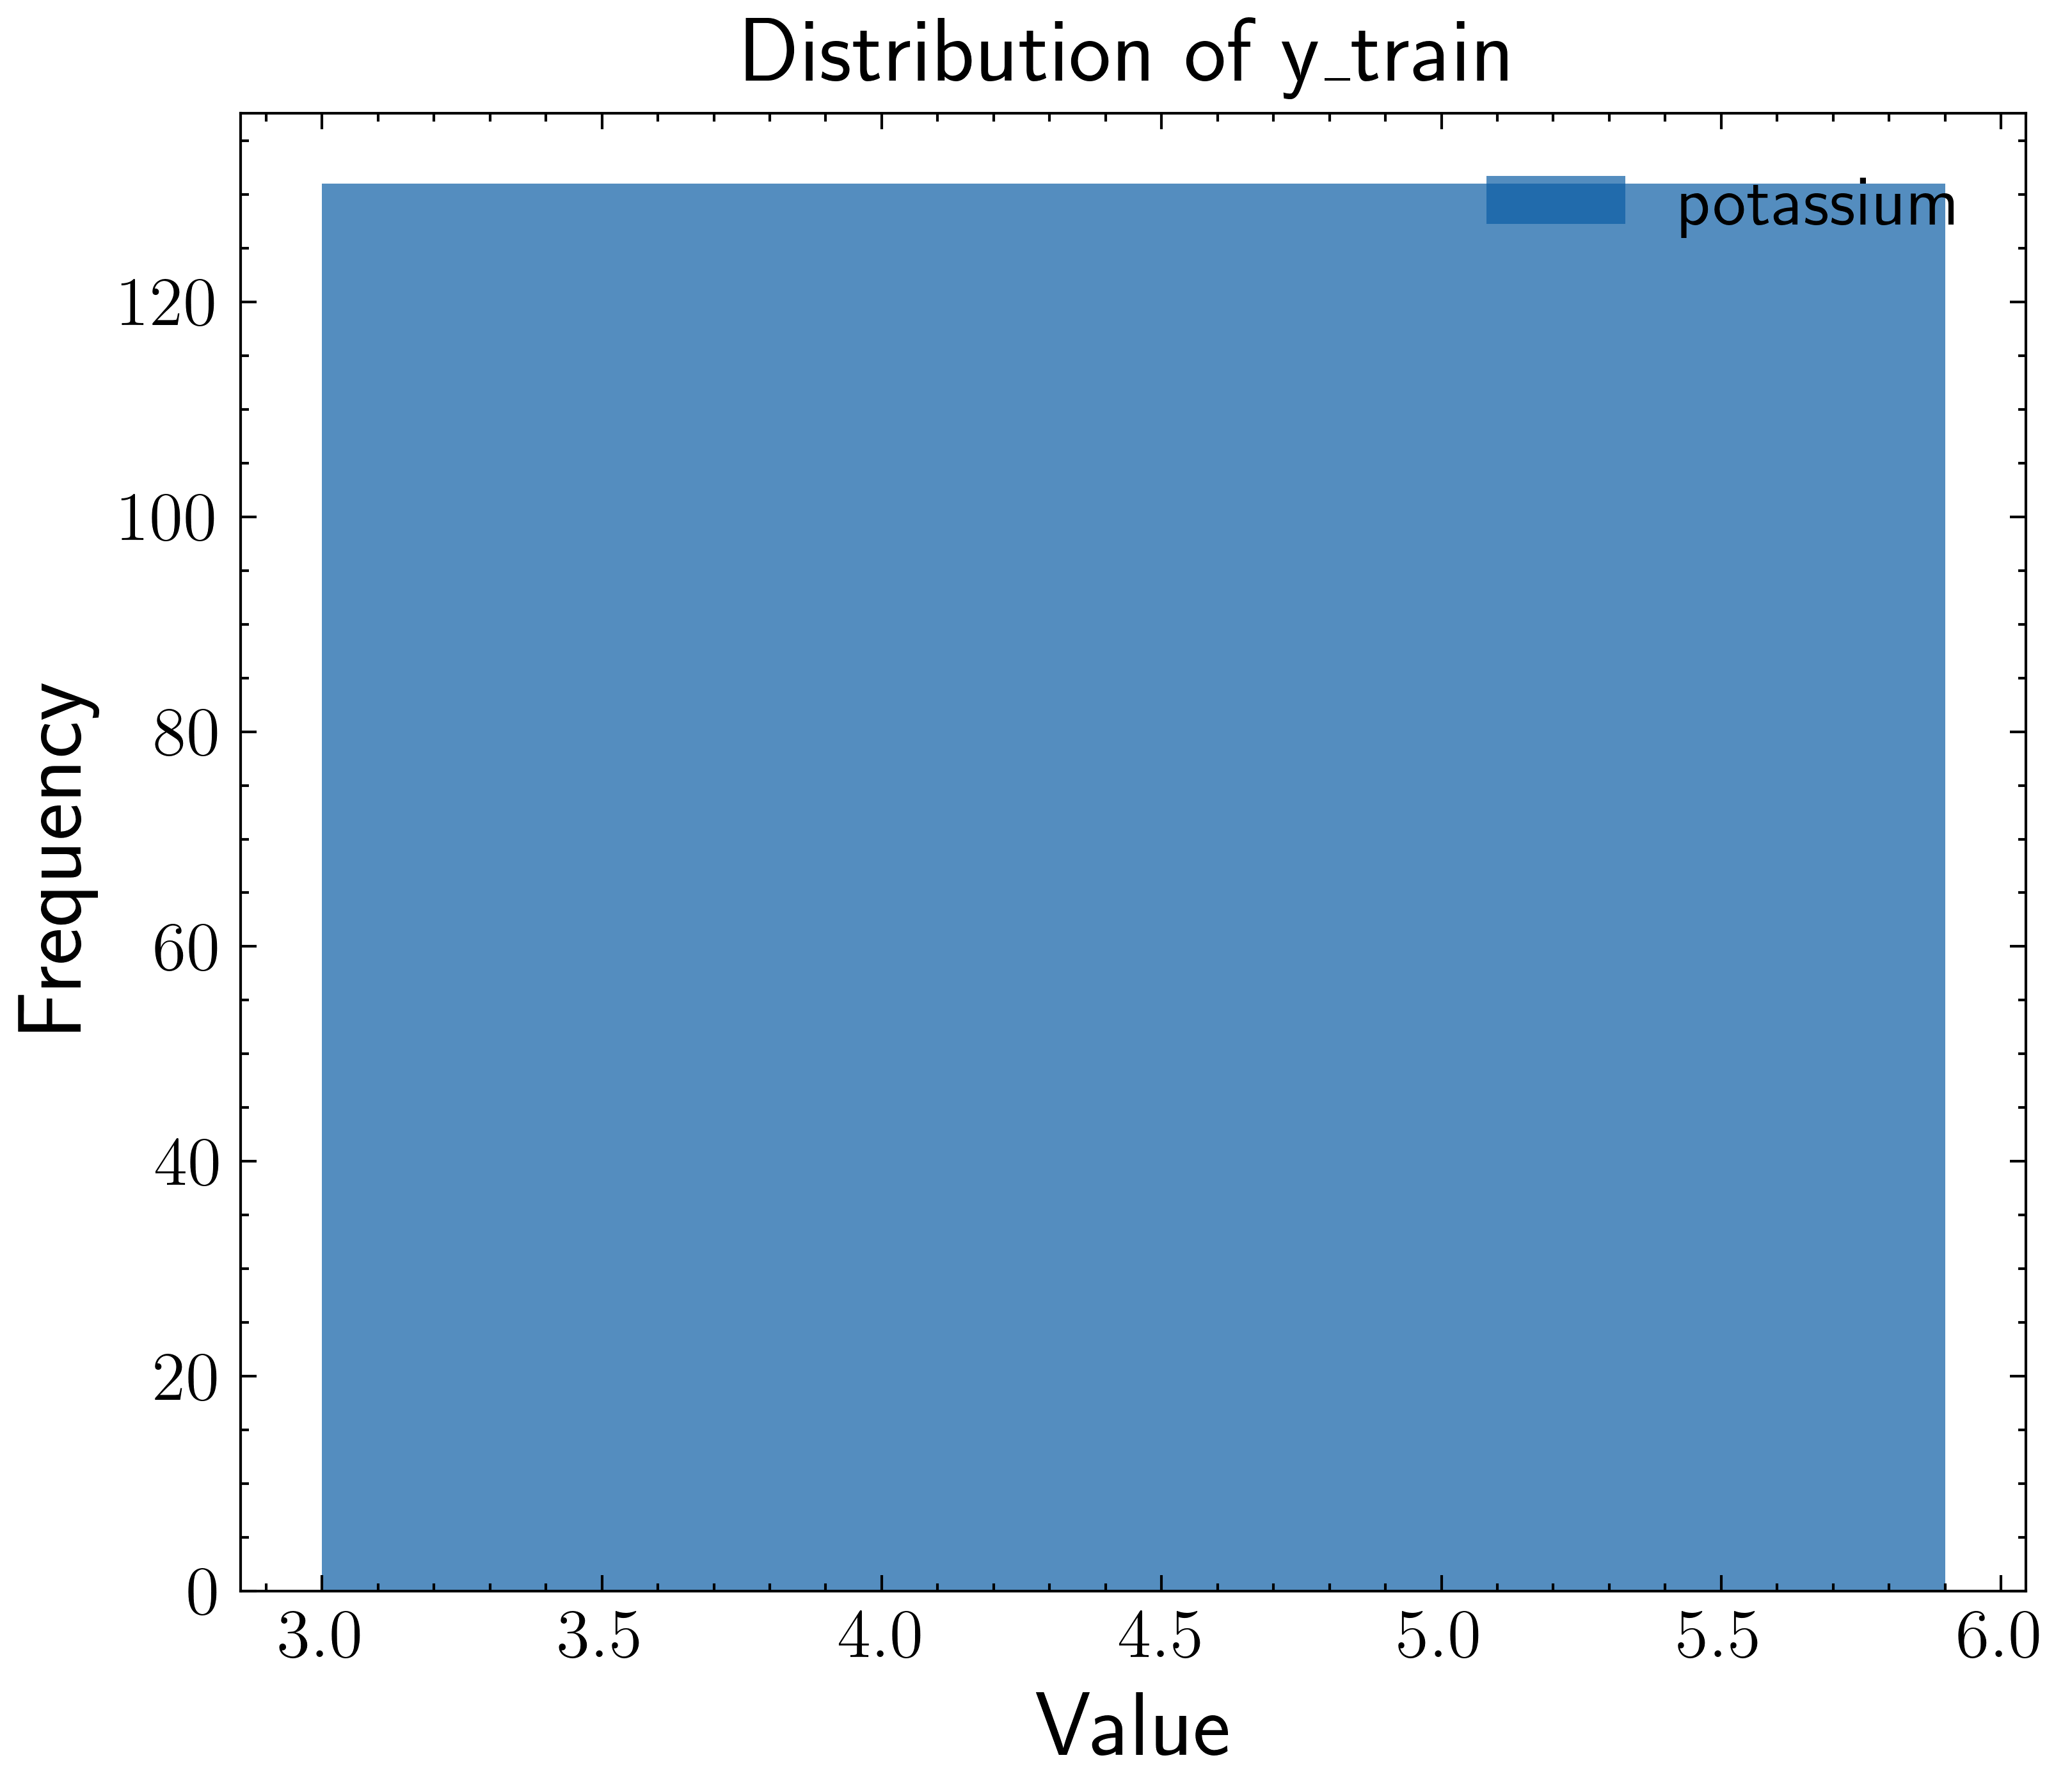

In [7]:
X_train, y_train, X_test, y_test = torch.load(f"{DATASET_DIR}/dataset.pt")

y_k_train, y_k_test = y_train[:,0], y_test[:,0]
y_ca_train, y_ca_test = y_train[:,1], y_test[:,1]

from collections import Counter
import random

def oversample(X: torch.Tensor, y: torch.Tensor, rounding: int = 1, target_count: int = None):
    """
    Manually oversample by rounding continuous targets and duplicating underrepresented bins.

    Args:
        X (Tensor): shape [N, C, T]
        y (Tensor): shape [N]
        rounding (int): decimal rounding precision
        target_count (int): desired number of samples per group (if None, use max group size)

    Returns:
        X_oversampled, y_oversampled: oversampled tensors
    """
    # Round target to group similar values
    y_group = torch.round(y, decimals=rounding)
    group_values, group_indices = torch.unique(y_group, return_inverse=True)
    group_to_indices = {v.item(): (group_indices == i).nonzero(as_tuple=True)[0] for i, v in enumerate(group_values)}

    # Determine how many samples to create per group
    max_count = max(len(idx_list) for idx_list in group_to_indices.values())
    target_count = target_count or max_count

    new_X, new_y = [], []
    for val, indices in group_to_indices.items():
        num_samples = len(indices)
        needed = target_count - num_samples
        selected_indices = indices.tolist()

        # Always add current samples
        new_X.append(X[selected_indices])
        new_y.append(y[selected_indices])

        # Oversample if needed
        if needed > 0:
            dup_indices = random.choices(selected_indices, k=needed)
            new_X.append(X[dup_indices])
            new_y.append(y[dup_indices])

    # Concatenate all together
    X_os = torch.cat(new_X, dim=0)
    y_os = torch.cat(new_y, dim=0)
    return X_os, y_os

X_k_train, y_k_train = oversample(X_train, y_k_train)

plt.figure(figsize=(6, 5))
plt.hist(y_k_train.numpy(), bins=30, alpha=0.7)
plt.title('Distribution of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['potassium', 'calcium'])
plt.show()

In [8]:
# Create an empty dictionary
model_results = {'model_name': [], 'test_loss': [], SCORE_METRIC: []}
max_epochs = 30

def train_evaluate_cnn(current_X_train, y_train, current_X_test, y_test, model_name, config_dim=0):  
    cnn = models.CustomCNN()

    litcnn = models.LitCNN(
        model=cnn,
        loss_func=nn.MSELoss(),
        score_func=score_metric,
        metric_name=SCORE_METRIC.split('_')[1],
        is_classifier=False
    )

    train_set = TensorDataset(current_X_train, y_train)
    test_set = TensorDataset(current_X_test, y_test)
    train_set, val_set = utils.train_val_split(train_set)
    train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=NUM_WORKERS // 7, persistent_workers=True)
    val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

    trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=OUTPUT_DIR, callbacks=[models.LitProgressBar()])
    trainer.fit(litcnn, train_loader, val_loader)
    result = trainer.test(litcnn, test_loader)

    # Add current model results to the lists
    model_results['model_name'].append(model_name)
    model_results['test_loss'].append(result[0]['test_loss'])
    model_results[SCORE_METRIC].append(result[0][SCORE_METRIC])

    cvi = CustomVisualizer(litcnn, model_name)
    _, axes = cvi.create_subplot_grid(1, 2, figsize=(10, 4))
    cvi.plot_epoch_loss(max_epochs, ax=axes[0, 0])
    cvi.plot_actual_vs_predicted(test_loader, ax=axes[0, 1])
    plt.show()
    
    torch.cuda.empty_cache()
    return litcnn

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | CustomCNN | 5.6 K  | train
1 | loss_func | MSELoss   | 0      | train
------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4801953136920929     │
│          test_r2          │    -0.548052191734314     │
└───────────────────────────┴───────────────────────────┘

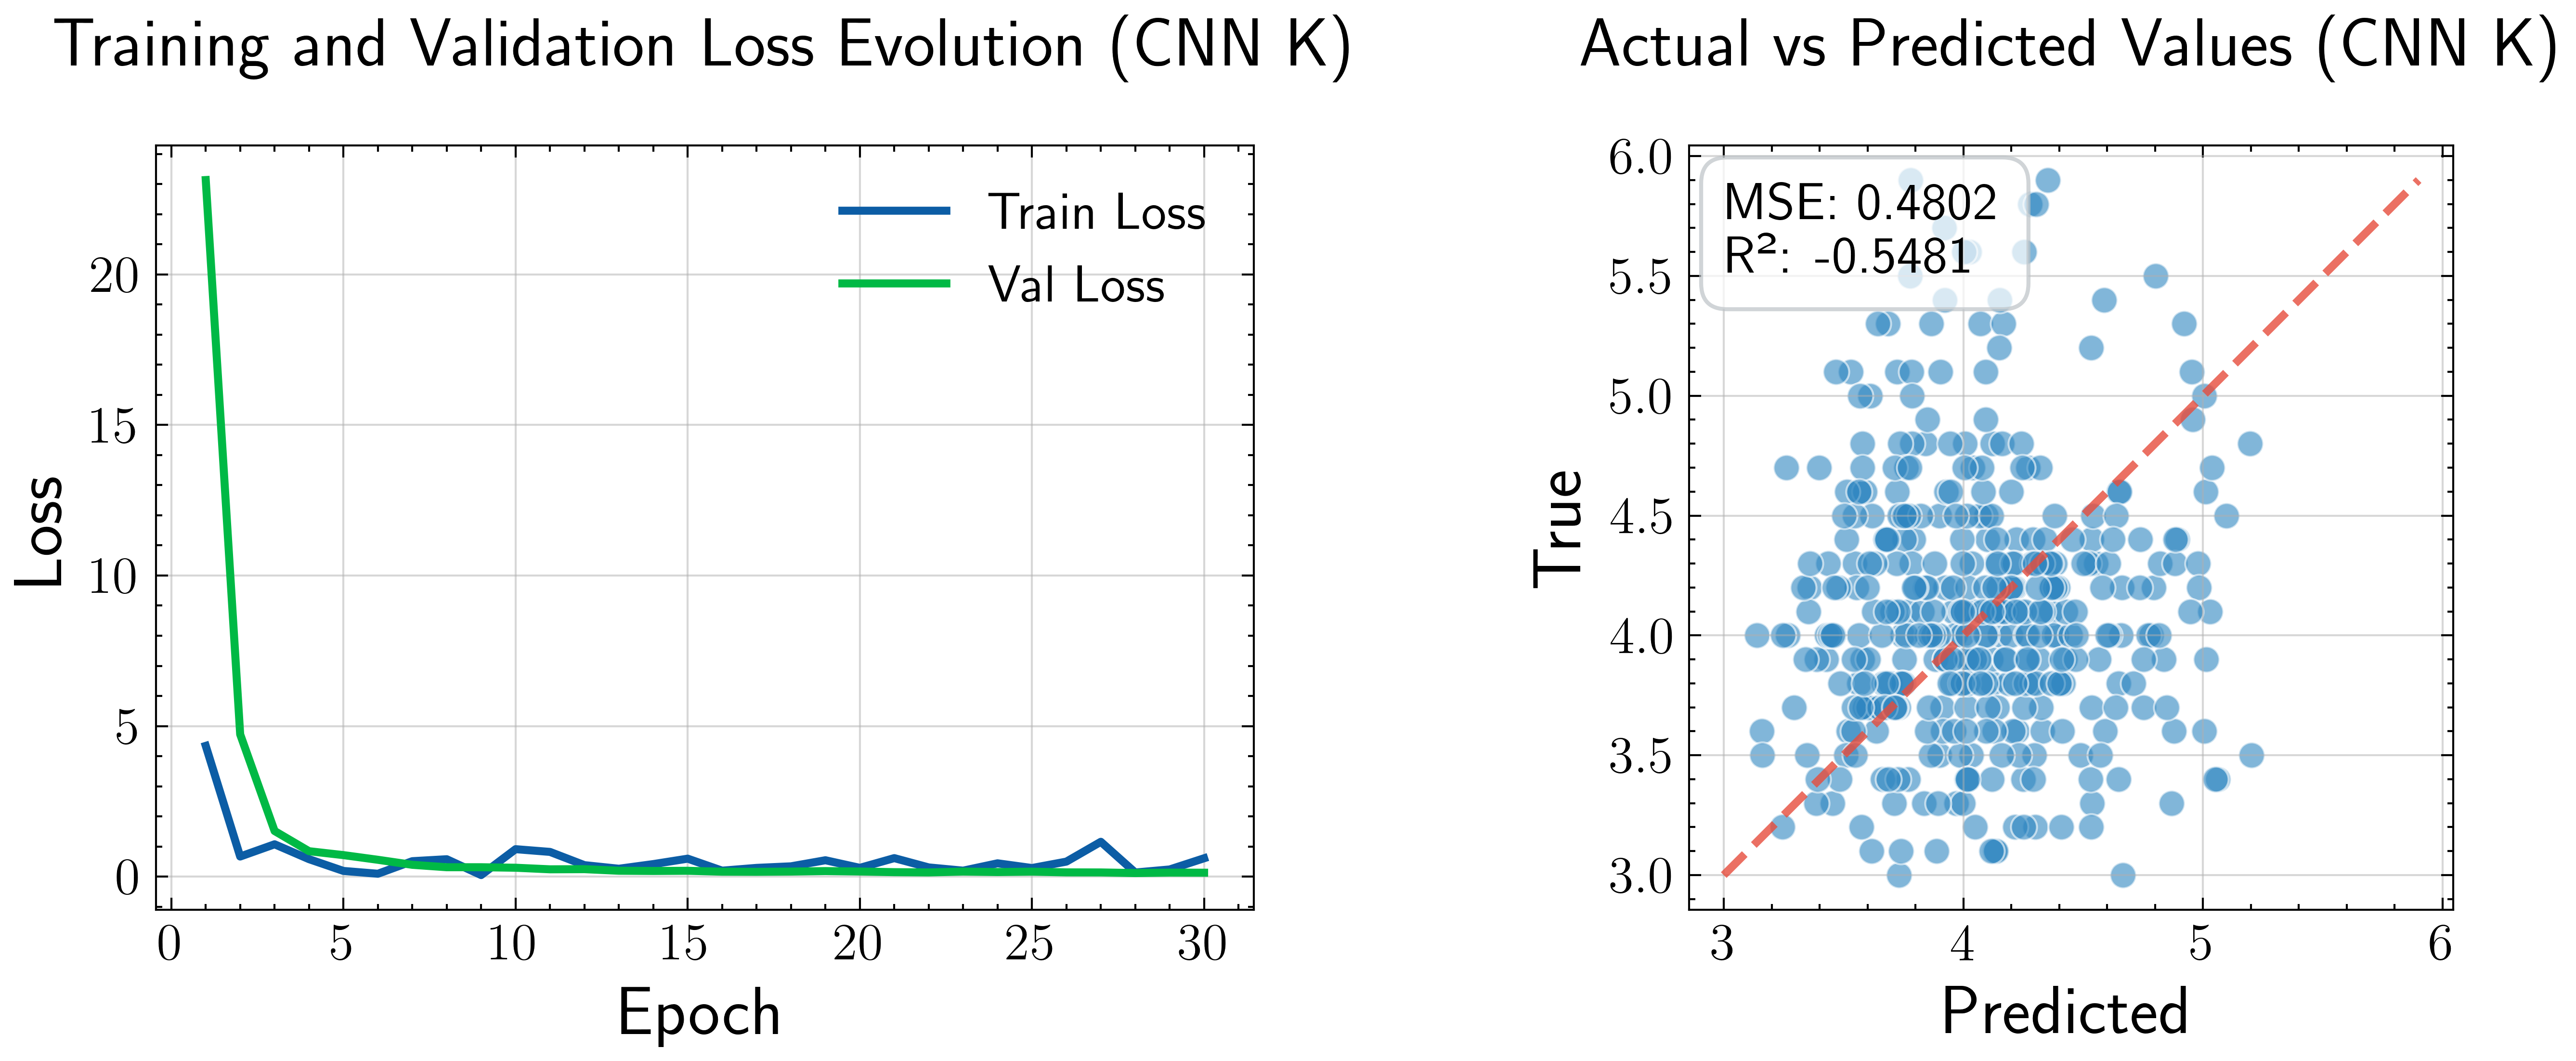

LitCNN(
  (model): CustomCNN(
    (separable_conv1): Sequential(
      (0): Conv1d(12, 12, kernel_size=(128,), stride=(1,), padding=same, groups=12)
      (1): Conv1d(12, 16, kernel_size=(1,), stride=(1,), padding=same)
      (2): ReLU(inplace=True)
      (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (separable_conv2): Sequential(
      (0): Conv1d(16, 16, kernel_size=(64,), stride=(1,), padding=same, groups=16)
      (1): Conv1d(16, 16, kernel_size=(1,), stride=(1,), padding=same)
      (2): ReLU(inplace=True)
      (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    )
    (separable_conv3): Sequential(
      (0): Conv1d(16, 16, kernel_size=(64,), stride=(1,), padding=same, groups=16)
      (1): Conv1d(16, 16, kernel_size=(1,), str

In [9]:
train_evaluate_cnn(X_k_train, y_k_train, X_test, y_k_test, "(CNN K)")